Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [51]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [52]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [53]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Cancer Detection/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Cancer Detection/Test')

In [54]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


 j### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [55]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [56]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset='training',
    image_size = (img_height,img_width),
    batch_size= batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [57]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset='validation',
    image_size = (img_height,img_width),
    batch_size= batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [58]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

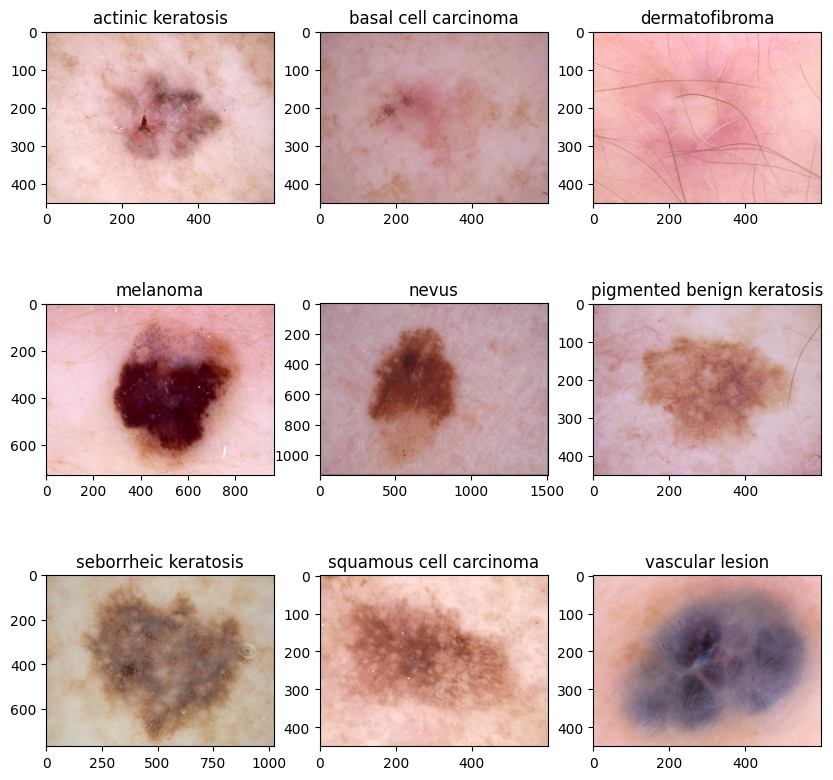

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [60]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [61]:
### Your code goes here
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1/225,input_shape = (img_height,img_width,3))])
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu',input_shape=(180,180,32)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [62]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [63]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Train the model

In [64]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 26s 180ms/step - loss: 2.0241 - accuracy: 0.2026 - val_loss: 1.9241 - val_accuracy: 0.2483
Epoch 2/20
56/56 [==============================] - 5s 90ms/step - loss: 1.9290 - accuracy: 0.2561 - val_loss: 1.9567 - val_accuracy: 0.2998
Epoch 3/20
56/56 [==============================] - 5s 91ms/step - loss: 1.8746 - accuracy: 0.2913 - val_loss: 1.9991 - val_accuracy: 0.2371
Epoch 4/20
56/56 [==============================] - 5s 88ms/step - loss: 1.8676 - accuracy: 0.2852 - val_loss: 1.7526 - val_accuracy: 0.3624
Epoch 5/20
56/56 [==============================] - 5s 90ms/step - loss: 1.6909 - accuracy: 0.3912 - val_loss: 1.6446 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.5867 - accuracy: 0.4386 - val_loss: 1.5537 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 5s 92ms/step - loss: 1.5375 - accuracy: 0.4459 - val_loss: 1.5407 - val_accuracy: 0.4787
Epoch 8/20
56/56 [====

### Visualizing training results

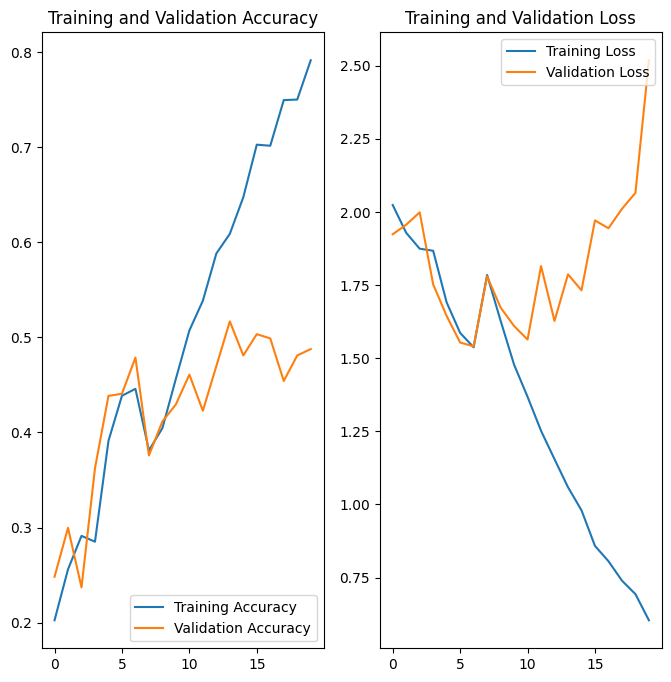

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
1. Accuracy is around 80% .
2. Model is  overfitting as we see difference in accuracy and loss function in training and test .


In [66]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augument = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2,fill_mode = 'reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3),fill_mode = 'reflect'),
])

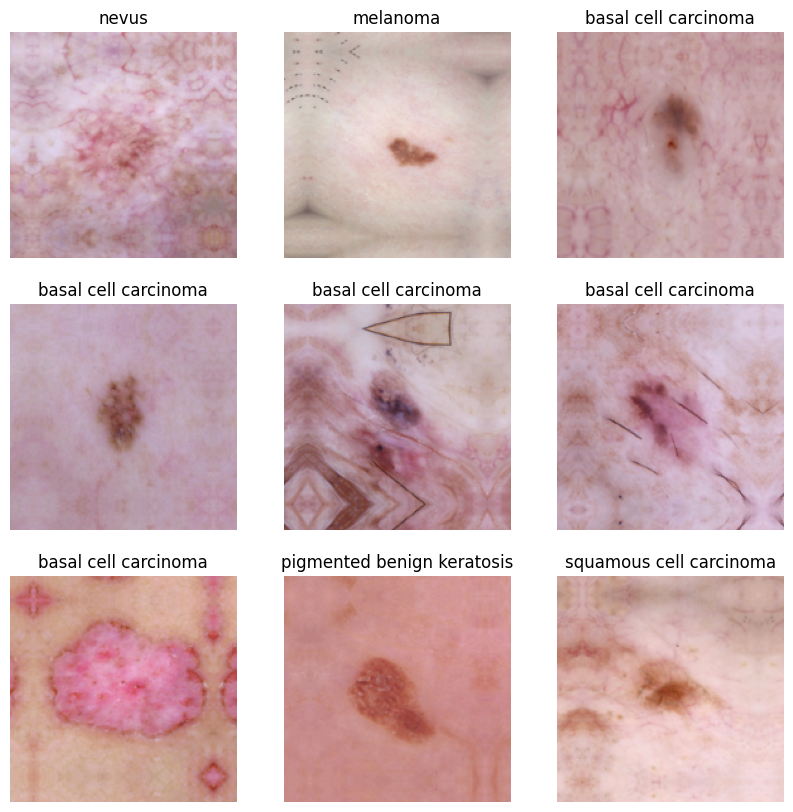

In [67]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [68]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1/225,input_shape = (img_height,img_width,3))])
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu',input_shape=(180,180,32)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [69]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [70]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 96ms/step - loss: 2.0630 - accuracy: 0.1942 - val_loss: 2.0315 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 91ms/step - loss: 2.0095 - accuracy: 0.2132 - val_loss: 1.9155 - val_accuracy: 0.2774
Epoch 3/20
56/56 [==============================] - 5s 91ms/step - loss: 1.9262 - accuracy: 0.2573 - val_loss: 1.7981 - val_accuracy: 0.3087
Epoch 4/20
56/56 [==============================] - 5s 91ms/step - loss: 1.8392 - accuracy: 0.3186 - val_loss: 1.7131 - val_accuracy: 0.3893
Epoch 5/20
56/56 [==============================] - 5s 92ms/step - loss: 1.7166 - accuracy: 0.3756 - val_loss: 1.6744 - val_accuracy: 0.4183
Epoch 6/20
56/56 [==============================] - 5s 90ms/step - loss: 1.6842 - accuracy: 0.4035 - val_loss: 1.7499 - val_accuracy: 0.3579
Epoch 7/20
56/56 [==============================] - 5s 92ms/step - loss: 1.5935 - accuracy: 0.4291 - val_loss: 1.7270 - val_accuracy: 0.3893
Epoch 8/20
56

### Visualizing the results

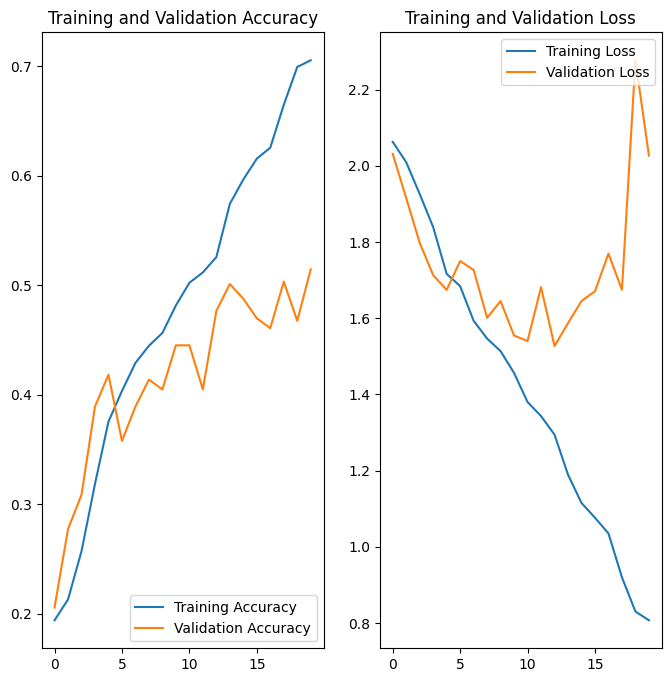

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is no improvement in the accuracy of training set but there is improvement in the accuracy of validation set , this shows the overfitting problem is resolved due to data augumentation.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

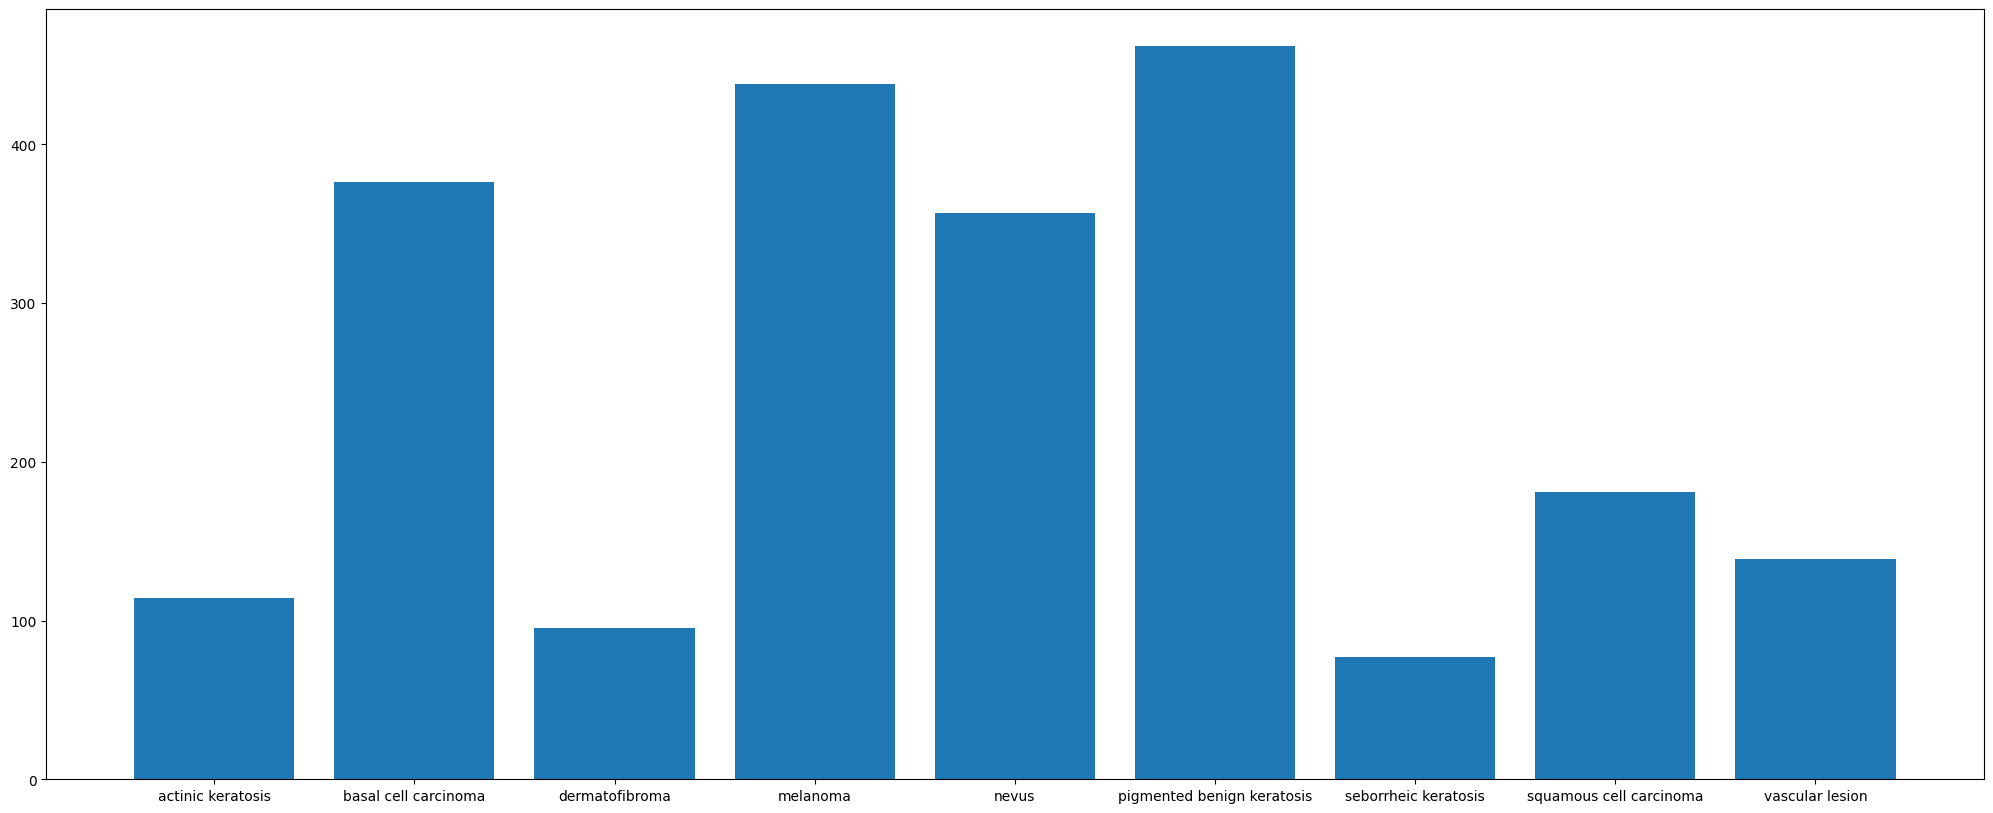

In [72]:
## Your code goes here.
count = []
for i in class_names:
  count.append(len(list(data_dir_train.glob(i+'/*jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
       Seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
          pigmented benign kratosis and melanoma

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [73]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [76]:
path_to_training_dataset="/content/drive/MyDrive/Cancer Detection/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AED320FEE60>: 100%|██████████| 500/500 [00:38<00:00, 13.04 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AED90457E20>: 100%|██████████| 500/500 [00:44<00:00, 11.23 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AED32C47670>: 100%|██████████| 500/500 [00:43<00:00, 11.59 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AEDA95E7A90>: 100%|██████████| 500/500 [00:42<00:00, 11.64 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AED2F548B20>: 100%|██████████| 500/500 [00:47<00:00, 10.54 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AED320904C0>: 100%|██████████| 500/500 [00:40<00:00, 12.26 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AEDA938EB60>: 100%|██████████| 500/500 [00:30<00:00, 16.26 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7AED2F62D690>: 100%|██████████| 500/500 [00:42<00:00, 11.65 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer Detection/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AED32EA41F0>: 100%|██████████| 500/500 [00:37<00:00, 13.30 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [84]:
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/Cancer Detection/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [86]:
path_list = []
lesion_list = []
for i in class_names:
  for j in data_dir_train1.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list,lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/drive/MyDrive/Cancer Detection/Train/...,actinic keratosis
1,/content/drive/MyDrive/Cancer Detection/Train/...,actinic keratosis
2,/content/drive/MyDrive/Cancer Detection/Train/...,actinic keratosis
3,/content/drive/MyDrive/Cancer Detection/Train/...,actinic keratosis
4,/content/drive/MyDrive/Cancer Detection/Train/...,actinic keratosis
...,...,...
4495,/content/drive/MyDrive/Cancer Detection/Train/...,vascular lesion
4496,/content/drive/MyDrive/Cancer Detection/Train/...,vascular lesion
4497,/content/drive/MyDrive/Cancer Detection/Train/...,vascular lesion
4498,/content/drive/MyDrive/Cancer Detection/Train/...,vascular lesion


In [87]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    941
melanoma                      853
basal cell carcinoma          748
nevus                         710
squamous cell carcinoma       389
vascular lesion               280
actinic keratosis             229
dermatofibroma                203
seborrheic keratosis          147
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [88]:
data_dir_train="/content/drive/MyDrive/Cancer Detection/Train/output"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [89]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [90]:
## your code goes here

num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1/225,input_shape = (img_height,img_width,3))])
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu',input_shape=(180,180,32)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [91]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [92]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


113/113 [==============================] - 31s 246ms/step - loss: 1.9483 - accuracy: 0.2578 - val_loss: 1.9980 - val_accuracy: 0.2656
Epoch 2/50
113/113 [==============================] - 26s 218ms/step - loss: 1.7022 - accuracy: 0.3714 - val_loss: 1.5705 - val_accuracy: 0.4256
Epoch 3/50
113/113 [==============================] - 26s 223ms/step - loss: 1.5756 - accuracy: 0.4314 - val_loss: 1.5384 - val_accuracy: 0.4333
Epoch 4/50
113/113 [==============================] - 27s 228ms/step - loss: 1.4960 - accuracy: 0.4656 - val_loss: 1.7085 - val_accuracy: 0.3611
Epoch 5/50
113/113 [==============================] - 29s 243ms/step - loss: 1.3910 - accuracy: 0.5114 - val_loss: 1.3332 - val_accuracy: 0.5233
Epoch 6/50
113/113 [==============================] - 31s 266ms/step - loss: 1.2315 - accuracy: 0.5742 - val_loss: 1.2391 - val_accuracy: 0.5633
Epoch 7/50
113/113 [==============================] - 26s 224ms/step - loss: 1.1557 - accuracy: 0.5944 - val_loss: 1.2255 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

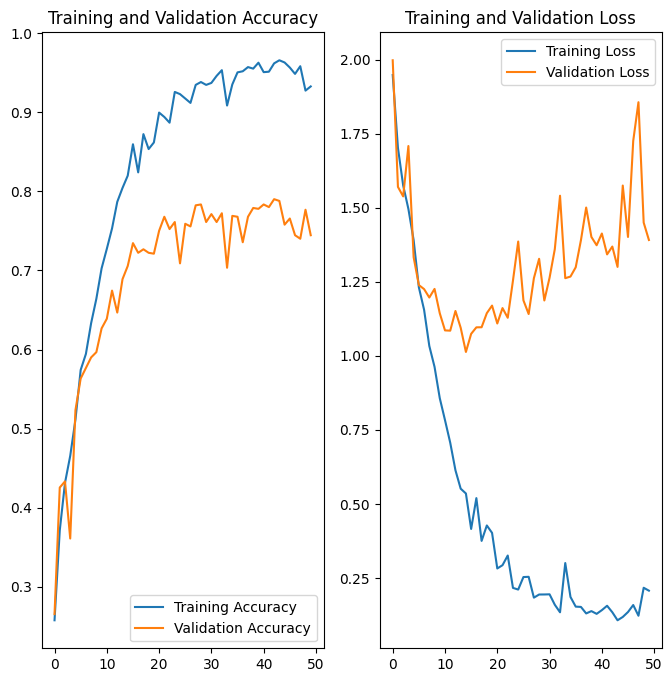

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1. Accuracy on training has increased on sing Augmentor library.
2. There is some overfitting which can be resolved by adding more dropout layers.